In [108]:
import numpy as np
import pandas as pd
import pdb
from ipynb.fs.full.Game import *
import random # import randrange

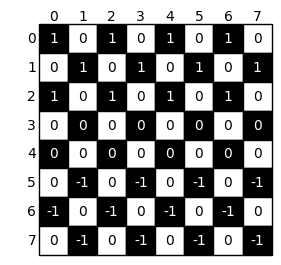

In [15]:
board_1 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])
state = [board_1, -1]
visualize(state)

In [16]:
action_space = [(0,4),#0
 (1,4),#1
 (1,5),#2
 (2,5),#3
 (2,6),#4
 (3,6),#5
 (3,7),#6
 (4,0),#7
 (4,1),#8
 (4,8),#9
 (4,9),#10
 (5,1),#11
 (5,2),#12
 (5,9),#13
 (5,10),#14
 (6,2),#15
 (6,3),#16
 (6,10),#17
 (6,11),#18
 (7,3),#19
 (7,11),#20
 (8,4),#21
 (8,12),#22
 (9,4),#23
 (9,5),#24
 (9,12),#25
 (9,13),#26
 (10,5),#27
 (10,6),#28
 (10,13),#29
 (10,14),#30
 (11,6),#31
 (11,7),#32
 (11,14),#33
 (11,15),#34
 (12,8),#35
 (12,9),#36
 (12,16),#37
 (12,17),#38
 (13,9),#39
 (13,10),#40
 (13,17),#41
 (13,18),#42
 (14,10),#43
 (14,11),#44
 (14,18),#45
 (14,19),#46
 (15,11),#47
 (15,19),#48
 (16, 12),#49
 (16, 20),#50
 (17, 12),#51
 (17, 13),#52
 (17, 20),#53
 (17, 21),#54
 (18, 13),#55
 (18, 14),#56
 (18, 21),#57
 (18, 22),#58
 (19, 14),#59
 (19, 15),#60
 (19, 22),#61
 (19, 23),#62
 (20, 16),#63
 (20, 17),#64
 (20, 24),#65
 (20, 25),#66
 (21, 17),#67
 (21, 18),#68
 (21, 25),#69
 (21, 26),#70
 (22, 18),#71
 (22, 19),#72
 (22, 26),#73
 (22, 27),#74
 (23, 19),#75
 (23, 27),#76
 (24, 20),#77
 (24, 28),#78
 (25, 20),#79
 (25, 21),#80
 (25, 28),#81
 (25, 29),#82
 (26, 21),#83
 (26, 22),#84
 (26, 29),#85
 (26, 30),#86
 (27, 22),#87
 (27, 23),#88
 (27, 30),#89
 (27, 31),#90
 (28, 24),#91
 (28, 25),#92
 (29, 25),#93
 (29, 26),#94
 (30, 26),#95
 (30, 27),#96
 (31, 27)]#97

# Q table

## game over

In [17]:
def initialise_board(initial_board, agent, Q_color, color_boards):
    '''Function that creates ind_board (that will be assigned to it in the Q table) for a given board and adds the board to color board'''
    #case where board is not already in white_boards/black_board
    if sum([(initial_board == board).all() for board in color_boards.values()]) == 0:
        #initialise board in Q table
        ind_board = len(color_boards)
        #color_boards = np.append(color_boards, [initial_board], axis=0)
        color_boards[ind_board] = initial_board
        #add board index as row in Q
        Q_color.loc[ind_board] = 0

    #case where board was already seen
    else: 
        #retrieve ind_board for the already seen board
        ind_board = [key for key, value in color_boards.items() if (initial_board == value).all()][0]
    return ind_board, color_boards #is ind_board sufficient?

In [18]:
def find_move(initial_board, agent, ind_board, Q_color, epsilon, color_mult_caps_dict = {}):
    '''randomly selects a decimal (0,1) if < than epsilon the move is chosen randomly, else the highest Q_val is taken 
                                High ε means exploration, low ε means explotation
        This is repeated until a legal move is found, if move is illegal the Q_vla +=-1000. Once the move is legal it analyses whether 
        it's a multiple caps move. If so it updates the color_multi_caps_dict or makes sure the right format is outputted, i.e. a tuple
        in case of a simple move a list in case of cap.'''
    is_legal = False
    explotation_idx = random.uniform(0, 1)
    while is_legal == False:
        if explotation_idx < epsilon:
            #choose randomly
            my_move = random.choice((Q_color.loc[ind_board, Q_color.loc[ind_board] > -1000]).index)
            full_state = [initial_board, agent, my_move]
            is_legal, caps = referee(action_space, full_state)

        else:#explotation
            #choose move by selecting the max col in row representing current board
            moves = list(Q_color.loc[ind_board, Q_color.loc[ind_board] == max(Q_color.loc[ind_board])].index)
            #if more than one optimal move
            if len(moves)>1: 
                #random choice ##TO BE DISCUSSED  ###seems okay (Fede 11/01/2025)
                my_move = random.choice(moves)
            else:
                my_move = moves[0]
        
            full_state = [initial_board, agent, my_move]
            is_legal, caps = referee(action_space, full_state)
        if not is_legal:
            #set move to -1000 (i.e. illegal)
            Q_color.at[ind_board, my_move] += -1000
    #pdb.set_trace()
    #NOW my_move is legal
    if caps != 0:
        # RARE: if there are multiple double caps with the same first cap
        if len(caps) > 1 and len(caps[0]) > 1 and len(set(item[0] for item in caps if len(item) > 0)) < len(caps):
            #add board to nested dict of situation with multiple caps for white
            if ind_board not in color_mult_caps_dict.keys():
                color_mult_caps_dict[ind_board] = {}
                for mov in caps:
                    color_mult_caps_dict[ind_board][str(mov)] = 0
                if explotation_idx < epsilon:
                    my_move = random.choice(list(color_mult_caps_dict[ind_board].keys()))
                    my_move = [mov for mov in caps if str(mov) == my_move][0]
                else:
                    my_move = max(color_mult_caps_dict[ind_board], key=color_mult_caps_dict[ind_board].get)
                    my_move = [mov for mov in caps if str(mov) == my_move][0]
      
            else:
                if explotation_idx < epsilon:
                    my_move = random.choice(list(color_mult_caps_dict[ind_board].keys()))
                    my_move = [mov for mov in caps if str(mov) == my_move][0]
                else:
                    my_move = max(color_mult_caps_dict[ind_board], key=color_mult_caps_dict[ind_board].get)
                    my_move = [mov for mov in caps if str(mov) == my_move][0]

        #case when there're more than one multiple caps but with different first cap
        elif len(caps) > 1 and len(caps[0]) > 1 and len(set(item[0] for item in caps if len(item) > 0)) == len(caps):
            # Find the corresponding multi_cap in caps
            final_move = [multi_cap for multi_cap in caps if multi_cap[0] == my_move]
            my_move = final_move[0] #returns list e.g. [(18, 14), (11, 6)]
            
        #case when there's one possible cap
        elif len(caps) == 1:
            my_move = caps[0]
            #returns list e.g. [(18, 14), (11, 6)]

       #case when there're multiple single caps 
        elif len(caps) > 1 and len(caps[0]) == 1:
            my_move = [my_move] 
    
    return my_move #it's a list if it's a capture otherwise a tuple

In [19]:
def update_board(initial_board, agent, ind_board, my_move, color_boards, color_moves, turns_without_cap = 0):
    '''updates new board by calling the nextState function (which takes also care of the numbers of turns without cap)
       prints the boards by calling the visualize function
       updates the color_moves dictionary, color_moves[ind_board].append(my_move) if the len of color_moves[ind_board] = 2 then this is the
       third time this boards the game is over and returns new_board with turns_without_cap = 100
    '''
    #updates board after move
    #if there is a cap
    #pdb.set_trace()
    if isinstance(my_move, list):
        #turns_without_cap = 0
        for cap in my_move:
            initial_board, turns_without_cap = nextState([initial_board, agent, cap], cap, turns_without_cap)
    #normal move - e.g. no captures 
    else:
        initial_board, turns_without_cap = nextState([initial_board, agent, my_move], my_move, turns_without_cap)
    #visualize([initial_board, agent])

    #add to history of moves in this game
    if ind_board in color_moves: # Check if ind_board exists in color_moves
        #check if this position has already appeared twice - if so end the game
        if len(color_moves[ind_board]) >= 3: 
            turns_without_cap = 100
            return initial_board, turns_without_cap, color_boards, color_moves
        color_moves[ind_board].append(my_move)
    else:  # If it doesn't exist, set my_move as the value
        if isinstance(my_move, tuple): 
            color_moves[ind_board] = [my_move]
        else:
            color_moves[ind_board] = my_move
    return initial_board, turns_without_cap, color_boards, color_moves

In [20]:
def play_game(initial_board, agent, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, epsilon, turns_without_cap = 0):
    '''for white: calls the initialise_board to create ind_board and update white_boards then calls find_move to be fed to update_board 
    that updates board and turns_without_caps. Agent is changed, it will then check if game is over for the black (makes sense since white
    just played you can't lose on your move) if game is not over then call play_game again with updated parameters - it's now black's turn
    otherwise returns winner 
    '''
    #pdb.set_trace()
    if agent == -1:
        print("its whites' turn")
        input()
        ind_board, white_boards = initialise_board(initial_board, agent, Q_white, white_boards)
        move = find_move(initial_board, agent, ind_board, Q_white, epsilon, white_mult_caps_dict)
        new_board, turns_without_cap, white_boards, white_moves = update_board(
            initial_board, agent, ind_board, move, white_boards, white_moves, turns_without_cap)
        agent = 1
        #visualize([new_board, agent])
        winner = game_over(new_board, agent, action_space, turns_without_cap)
        if winner is None:
            return play_game(new_board, agent, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, epsilon, 
                             turns_without_cap)
        else:
            if winner > 0:
                print("Black wins the game!")
            elif winner < 0:
                print("White wins the game!")
            else:
                "It's a tie"    
        return winner

    elif agent == 1:
        print("its black's turn")
        input()
        ind_board, black_boards_boards = initialise_board(initial_board, agent, Q_black, black_boards)
        move = find_move(initial_board, agent, ind_board, Q_black, epsilon, black_mult_caps_dict)
        new_board, turns_without_cap, black_boards, black_moves = update_board(
            initial_board, agent, ind_board, move, black_boards, black_moves, turns_without_cap)
        agent = -1
        #visualize([new_board, agent])
        winner = game_over(new_board, agent, action_space, turns_without_cap)
        #pdb.set_trace()
        if winner is None:
            return play_game(new_board, agent, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, epsilon,
                             turns_without_cap)
        else:
            if winner > 0:
                print("Black wins the game!")
            elif winner < 0:
                print("White wins the game!")
            else:
                "It's a tie"
        return winner#, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves
            

In [21]:
def game_over(board, agent, action_space, turns_without_cap):
    '''function checks whether game is over and returns tuple bool and winner (as an int)'''
    res = []
    #pdb.set_trace()
    if turns_without_cap >= 80: 
        return 0
    for move in action_space:
        res.append(referee(action_space, [board, agent, move])[0])
    
    #no move is legal then game is over and the other agent wins    
    if not any(res):
        winner = - agent
        return winner
    else:    
        return None

In [22]:
def training(winner, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, 
             white_mult_caps_dict, black_mult_caps_dict, learning_rate, discount_factor):
    '''if there's a winner 
    '''
    # Update for white
    #pdb.set_trace()
    if not winner:
        return None 
    white_idx_boards = list(white_moves.keys())
    white_list_moves = list(white_moves.values())
    for move_number in reversed(range(len(white_idx_boards))):
        ind_board = white_idx_boards[move_number]
        move = white_list_moves[move_number]
        reward = 10 if winner == -1 else -10  # Reward for white (1 if white won, -1 if lost)
        next_ind_board = white_idx_boards[move_number + 1] if move_number != len(white_idx_boards) - 1 else None
        max_future_q = Q_white.loc[next_ind_board, :].max() if next_ind_board else 0
        #pdb.set_trace()
        if len(move) == 1:
            Q_white.loc[ind_board, move] += learning_rate * (reward + discount_factor * max_future_q - Q_white.loc[ind_board, move])
        else: 
            Q_white.loc[ind_board, [move[0]]] += learning_rate * (reward + discount_factor * max_future_q - Q_white.loc[ind_board, [move[0]]])
            if ind_board in white_mult_caps_dict.keys():
                white_mult_caps_dict[ind_board][str(move)] += learning_rate * (reward + discount_factor 
                                                                          * max_future_q - Q_white.loc[ind_board, [move[0]]].item()) 

    
    # Update for black
    black_idx_boards = list(black_moves.keys())
    black_list_moves = list(black_moves.values())
    for move_number in reversed(range(len(black_idx_boards))):
        ind_board = black_idx_boards[move_number]
        move = black_list_moves[move_number]
        reward = 10 if winner == 1 else -10  # Reward for black (1 if black won, -1 if lost)
        next_ind_board = black_idx_boards[move_number + 1] if move_number != len(black_idx_boards) - 1 else None
        max_future_q = Q_black.loc[next_ind_board, :].max() if next_ind_board else 0
        if len(move) == 1:
            Q_black.loc[ind_board, move] += learning_rate * (reward + discount_factor * max_future_q - Q_black.loc[ind_board, move])
        else:
            Q_black.loc[ind_board, [move[0]]] += learning_rate * (reward + discount_factor * max_future_q - Q_black.loc[ind_board, [move[0]]])
            if ind_board in black_mult_caps_dict.keys():
                black_mult_caps_dict[ind_board][str(move)] += learning_rate * (reward + discount_factor 
                                                                          * max_future_q - Q_black.loc[ind_board, [move[0]]].item()) 


# Training 

In [23]:
board_1 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])

#df with each move in the action space as col and ind_board as index - for every row neg value if the move is illegal
Q_white = pd.DataFrame(data = 0, index=[0], columns=action_space)
Q_black = pd.DataFrame(data = 0, index=[0], columns=action_space)

#np array of boards seens by each agent - retrievable with ind_board e.g. white_boards[ind_board]
white_boards = {}
black_boards = {}

#dict of moves for the game played, ind_board is the key and the move select for that given idx board is the value
white_moves = {} #ind_board as key and move as value
black_moves = {}

#nested dict first key is ind_board, inside that another dict with caps as key and Q_value as value
#e.g. {ind_board: {(first_multi_cap: Q_value, second_multi_cap: Q_value)}}
white_mult_caps_dict = {}
black_mult_caps_dict = {}

its whites' turn


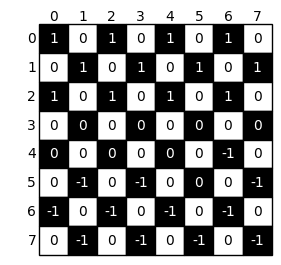

its black's turn


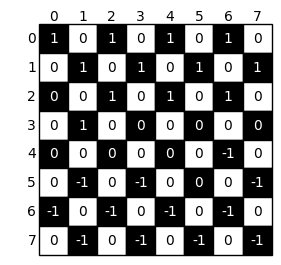

its whites' turn


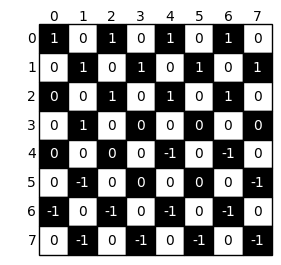

its black's turn


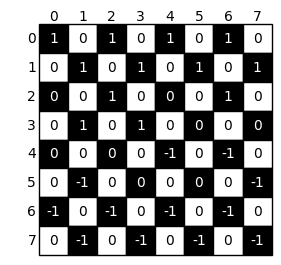

its whites' turn


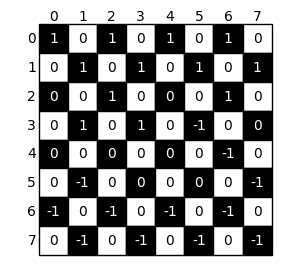

its black's turn


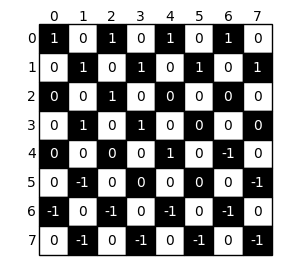

its whites' turn


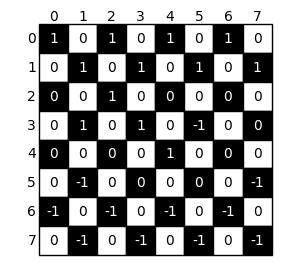

its black's turn


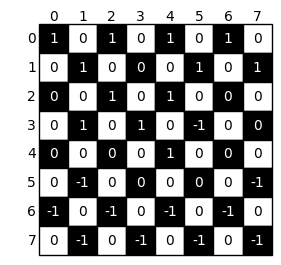

its whites' turn


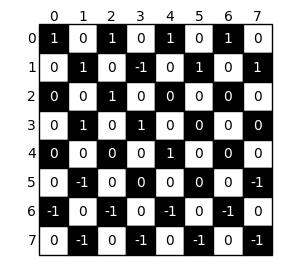

its black's turn


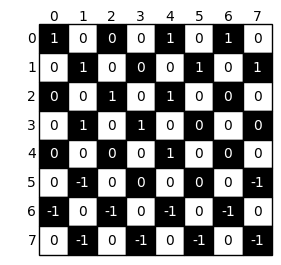

its whites' turn


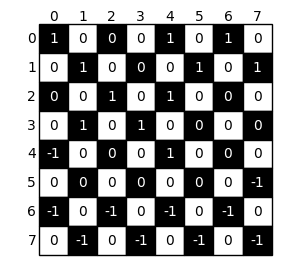

its black's turn


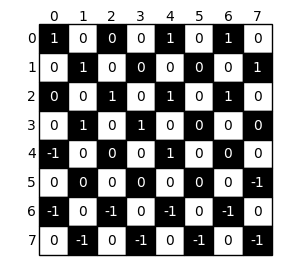

its whites' turn


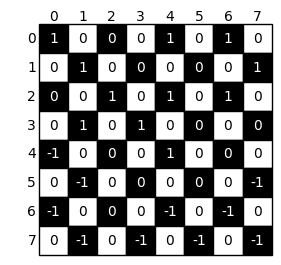

its black's turn


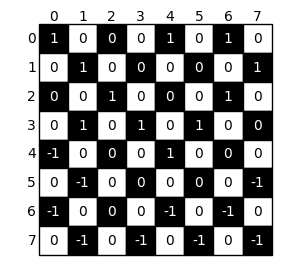

its whites' turn


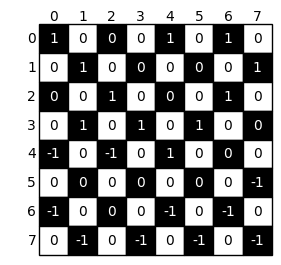

its black's turn


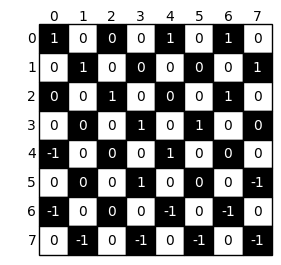

its whites' turn


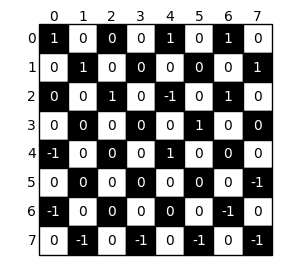

its black's turn


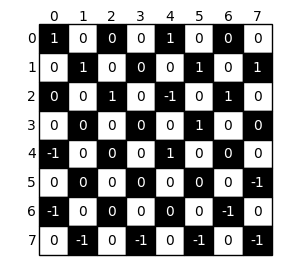

its whites' turn


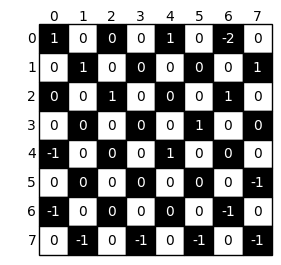

its black's turn


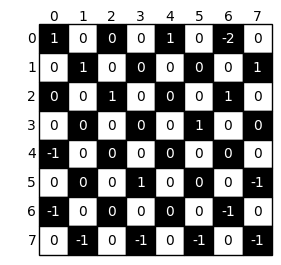

its whites' turn


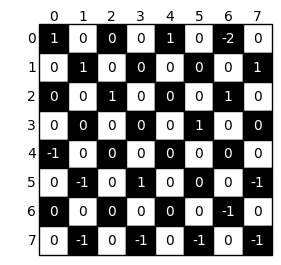

its black's turn


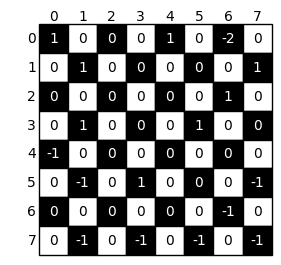

its whites' turn


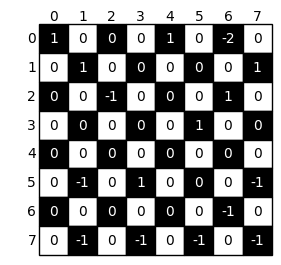

its black's turn


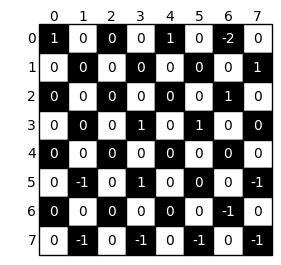

its whites' turn


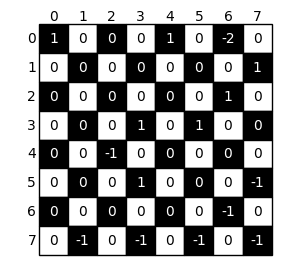

its black's turn


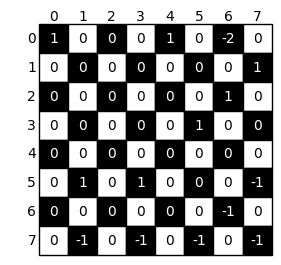

its whites' turn


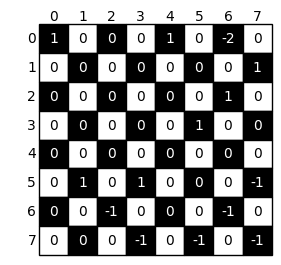

its black's turn


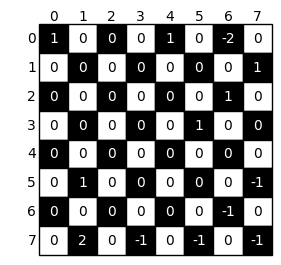

its whites' turn


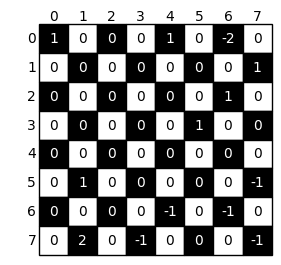

its black's turn


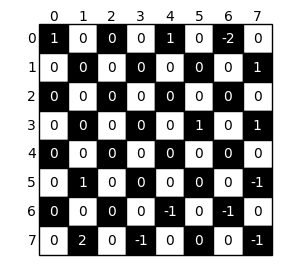

its whites' turn


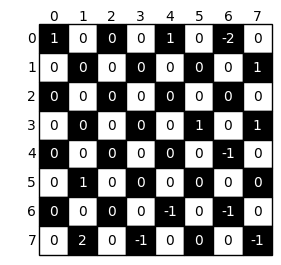

its black's turn


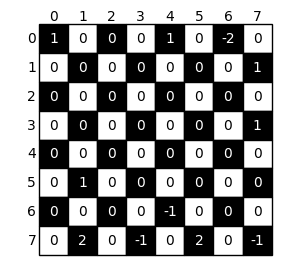

its whites' turn


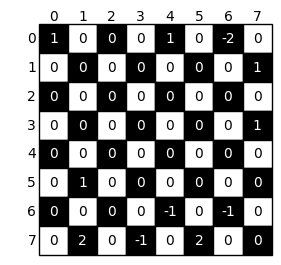

its black's turn


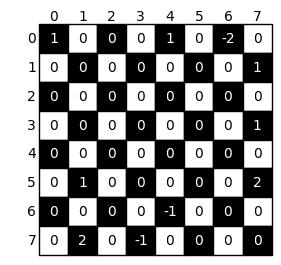

its whites' turn


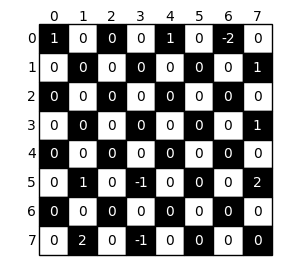

its black's turn


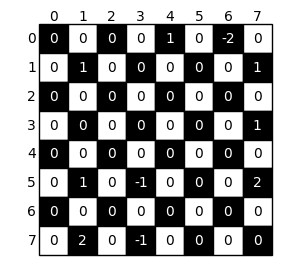

its whites' turn


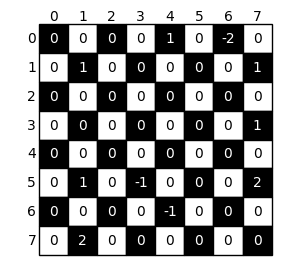

its black's turn


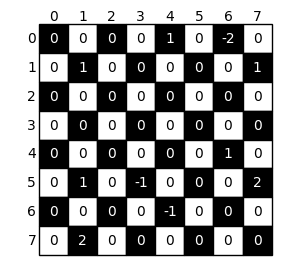

its whites' turn


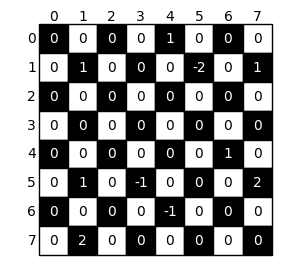

its black's turn


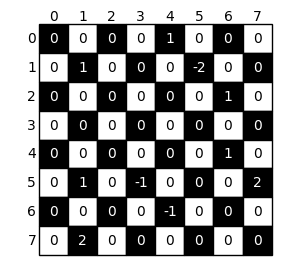

its whites' turn


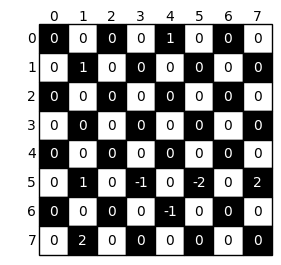

its black's turn


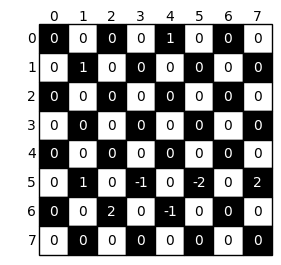

its whites' turn


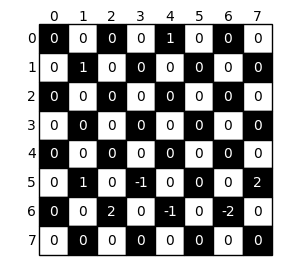

its black's turn


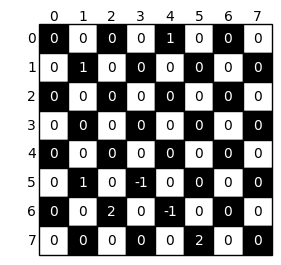

its whites' turn


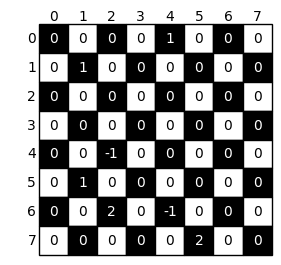

its black's turn


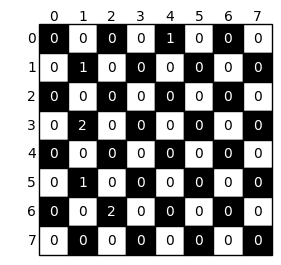

Black wins the game!


In [105]:
white_moves = {}
black_moves = {}
winner = play_game(board_1, -1, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, 0.9)

In [122]:
training(winner, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, 
             white_mult_caps_dict, black_mult_caps_dict, 0.1, 0.9)

# Testing

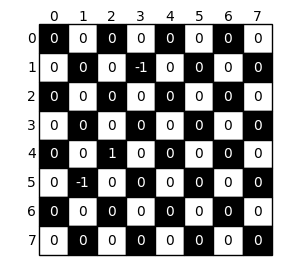

(array([ 0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 0,
 {0: array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,
          0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]),
  1: array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  1, -1,
          0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]),
  2: array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  0,  1,  0,  0,  1, -1,
         -1,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]),
  3: array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0, -1,
          1, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
  4: array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
          1, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
  5: array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
          1, -1

In [407]:
white_moves = {}
black_moves = {}
ind_board, white_boards = initialise_board(bb, -1, Q_white, white_boards)
my_move = find_move(bb, -1, ind_board, Q_white, 10, white_mult_caps_dict)
update_board(bb, -1, ind_board, my_move, white_boards, white_moves)

In [309]:
training(winner, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, 
             white_mult_caps_dict, black_mult_caps_dict, 0.1, 0.9)

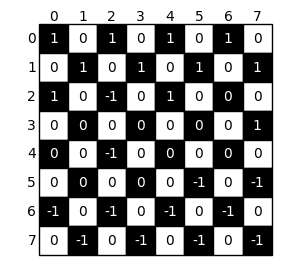

In [342]:
visualize([black_boards[2], 1])

In [413]:
find_move(bb, -1, ind_board, Q_white, 10, white_mult_caps_dict)

[(23, 19), (14, 10)]

# AI vs Human

In [69]:
def play_luigi(initial_board, agent, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, epsilon, 
                  turns_without_cap = 0):
    print("Do you wanna play W or B?")
    player = input()
    winner = None

    if player.lower() == 'w':
        while not winner:
            agent = -1
            winner = play_vs_black(initial_board, agent, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, epsilon, 
                  turns_without_cap = 0)
            
    elif player.lower() == 'b':
        while not winner:
            agent = -1
            winner = play_vs_white(initial_board, agent, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, epsilon, 
                  turns_without_cap = 0)         
        
    else:
        print('invalid input try again')
        return play_luigi()
        
    return winner

In [91]:
len(black_boards)

28074

In [103]:
Q_black.iloc[0].max(), Q_black.iloc[0].idxmax()
#Q_black.iloc[1][Q_black.iloc[1] > 0]

(1.2979690213868924, (8, 12))

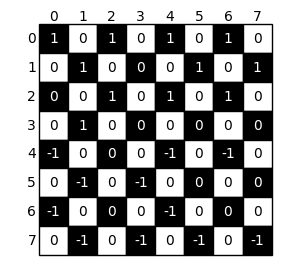

In [107]:
visualize([black_boards[28075], 1])

In [106]:
black_moves

{0: [(8, 12)],
 7445: [(10, 13)],
 28074: [(13, 18)],
 616: [(5, 10)],
 28075: [(2, 5)],
 28076: [(11, 15)],
 28077: [(15, 19)],
 28078: [(10, 13)],
 28079: [(13, 18)],
 28080: [(6, 10)],
 28081: [(9, 13)],
 28082: [(13, 17)],
 28083: [(18, 22)],
 28084: [(10, 13)],
 28085: [(1, 5)],
 28086: [(3, 6)],
 28087: [(6, 11)],
 28088: [(11, 14)],
 28089: [(0, 4)],
 28090: [(7, 11)],
 28091: [(11, 14)],
 28092: [(14, 18)]}

Do you wanna play W or B?


 w


play vs B


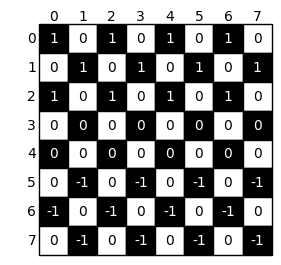

It's your turn, choose your move:


 20 16


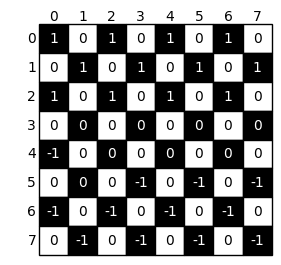

play vs B


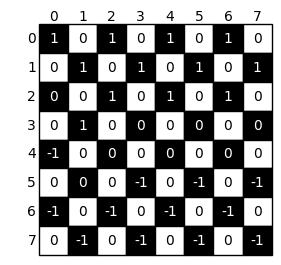

It's your turn, choose your move:


 22 18


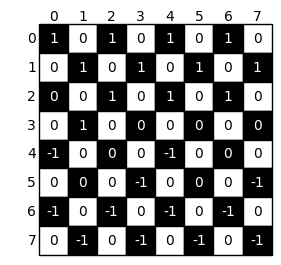

play vs B


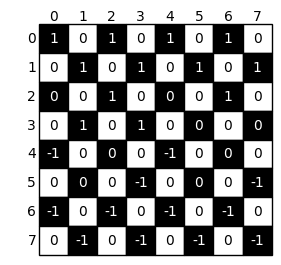

It's your turn, choose your move:


 23 19


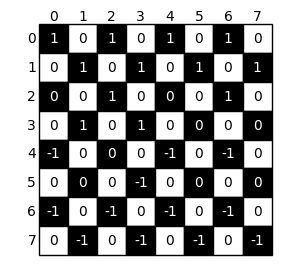

play vs B


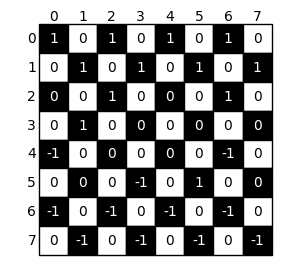

It's your turn, choose your move:


 27 22


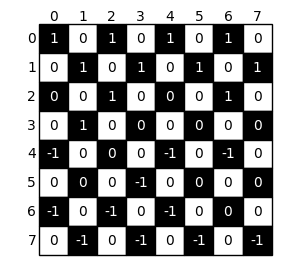

play vs B


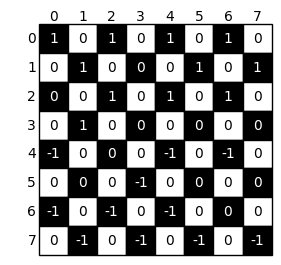

It's your turn, choose your move:


 25 20


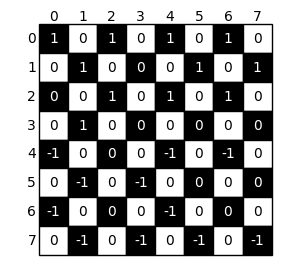

play vs B


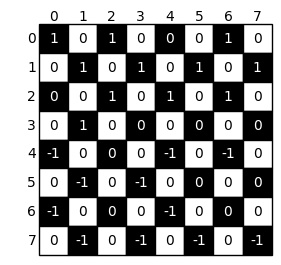

It's your turn, choose your move:


 20 17


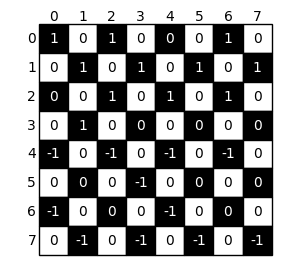

play vs B


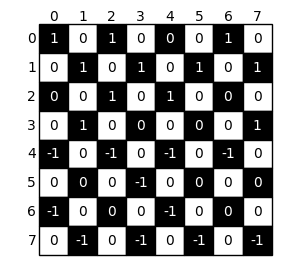

It's your turn, choose your move:


 17 12


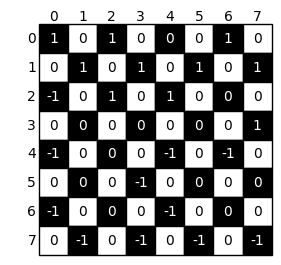

play vs B


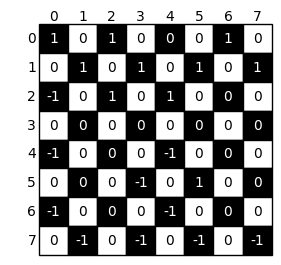

It's your turn, choose your move:


 26 22


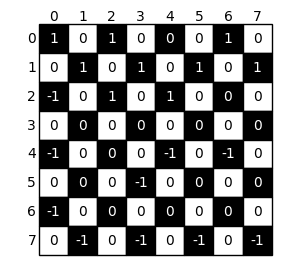

play vs B


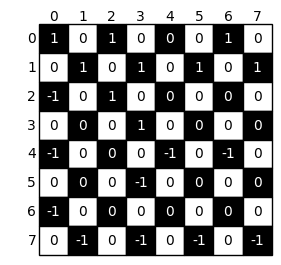

It's your turn, choose your move:


 18 14


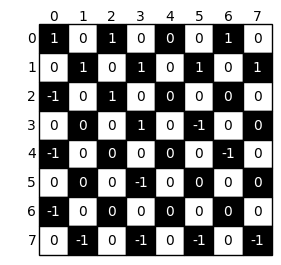

play vs B


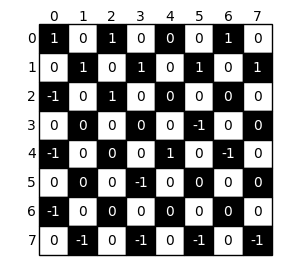

It's your turn, choose your move:


 21 17


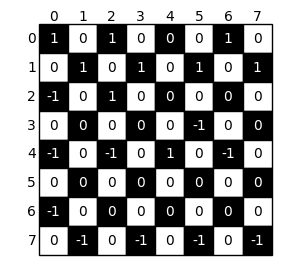

play vs B


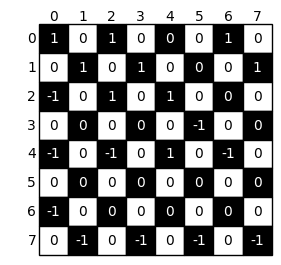

It's your turn, choose your move:


 31 27


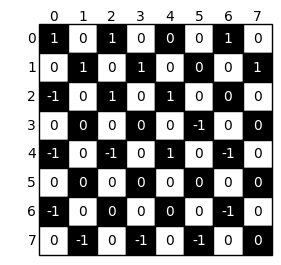

play vs B


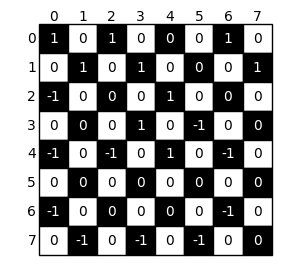

It's your turn, choose your move:


 28 25


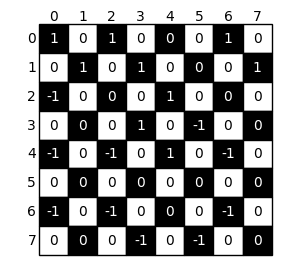

play vs B


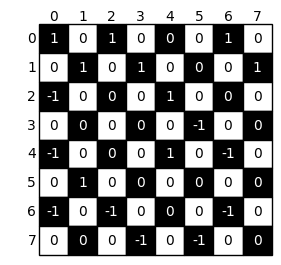

It's your turn, choose your move:


 24 20


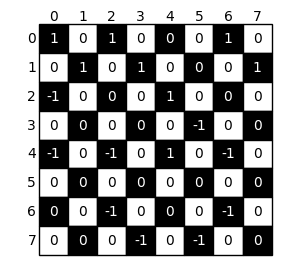

play vs B


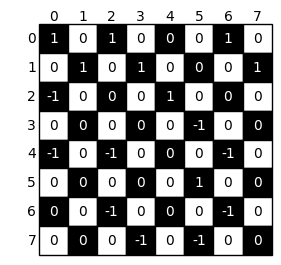

It's your turn, choose your move:


 27 22


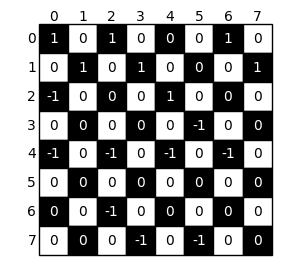

play vs B


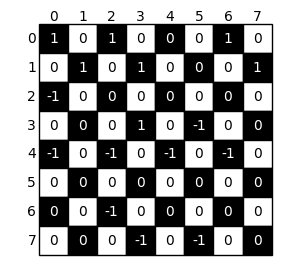

It's your turn, choose your move:


 17 13


invalid input, please type again


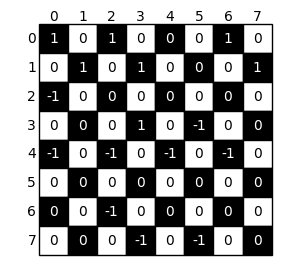

It's your turn, choose your move:


 18 13


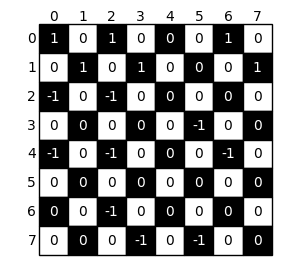

Force capture (9, 5)


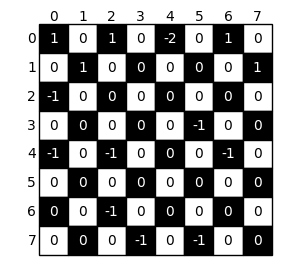

play vs B


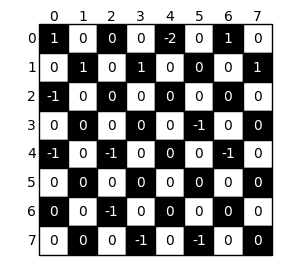

It's your turn, choose your move:


 2 5


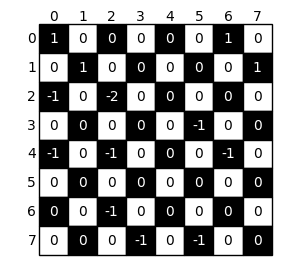

play vs B


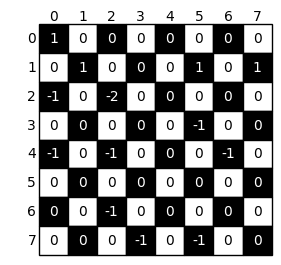

It's your turn, choose your move:


 17 13


invalid input, please type again


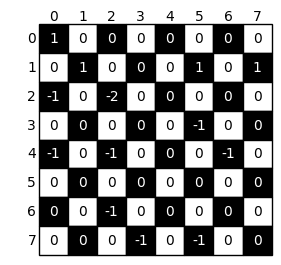

It's your turn, choose your move:


 8 4


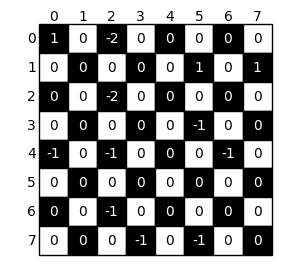

play vs B


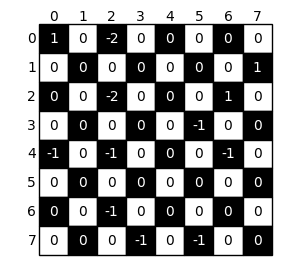

It's your turn, choose your move:


 9 13


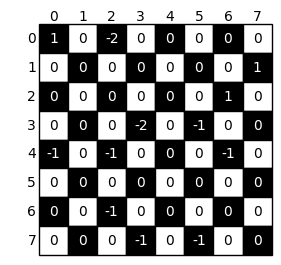

play vs B


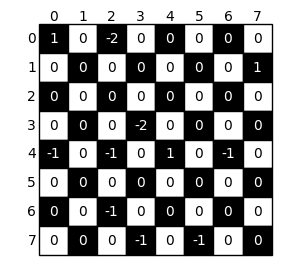

It's your turn, choose your move:


 13 18


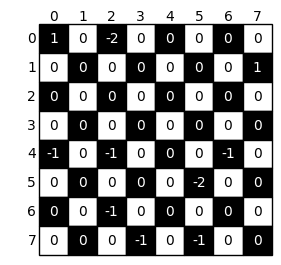

play vs B


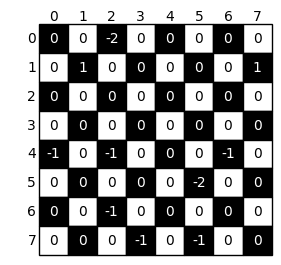

It's your turn, choose your move:


 1 4 


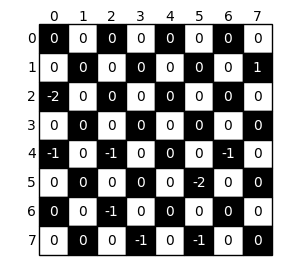

play vs B


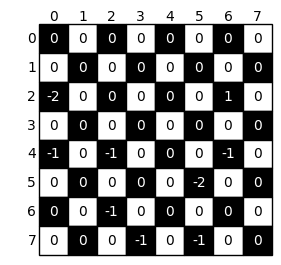

It's your turn, choose your move:


 19 15


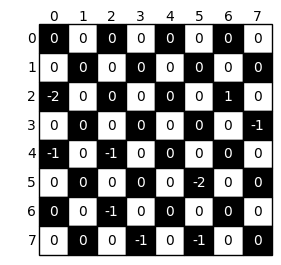

play vs B


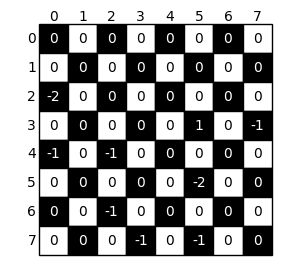

It's your turn, choose your move:


 15 11


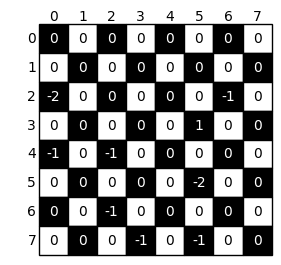

play vs B


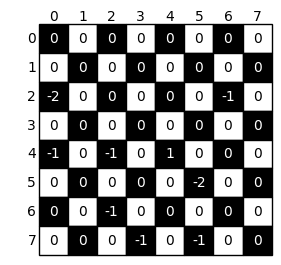

It's your turn, choose your move:


 22 18


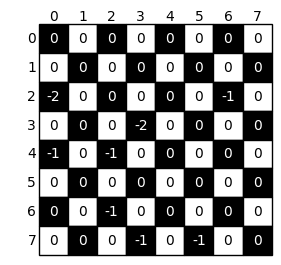

-1

In [105]:
white_moves = {}
black_moves = {}
play_luigi(board_1, -1, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, 0)

In [87]:
def play_vs_black(initial_board, agent, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, epsilon, 
                  turns_without_cap = 0):
    '''
    In a while loop, until there is a winner, it will run the choose_move function first and then let the AI play for black with find_move
    Returns the winner, i.e. -1, 1 or 0.
    '''
    winner = None
    while winner == None:
        print('play vs B')
        initial_board, agent, turns_without_cap = choose_move(initial_board, agent, turns_without_cap)
        #agent = 1
        winner = game_over(initial_board, agent, action_space, turns_without_cap)
        if winner == None:
            #pdb.set_trace()
            ind_board, black_boards = initialise_board(initial_board, agent, Q_black, black_boards)
            move = find_move(initial_board, agent, ind_board, Q_black, epsilon, black_mult_caps_dict)
            initial_board, turns_without_cap, black_boards, black_moves = update_board(
                initial_board, agent, ind_board, move, black_boards, black_moves, turns_without_cap)
            agent = -1
            #visualize([new_board, agent])
            winner = game_over(initial_board, agent, action_space, turns_without_cap)
        #pdb.set_trace()

    return winner

In [84]:
def play_vs_white(initial_board, agent, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, epsilon, 
                  turns_without_cap = 0):
    '''
    In a while loop, until there is a winner, it will play a the AI play for white with find_move and the call the choose_move for black
    Returns the winner, i.e. -1, 1 or 0.
    '''
    winner = None
    while winner == None:
        print('play vs W')
        print("its whites' turn")
        #visualize([initial_board, agent])
        ind_board, white_boards = initialise_board(initial_board, agent, Q_white, white_boards)
        move = find_move(initial_board, agent, ind_board, Q_white, epsilon, white_mult_caps_dict)
        initial_board, turns_without_cap, white_boards, white_moves = update_board(
            initial_board, agent, ind_board, move, white_boards, white_moves, turns_without_cap)
        agent = 1
        #visualize([new_board, agent])
        winner = game_over(initial_board, agent, action_space, turns_without_cap)
        #pdb.set_trace()
        if winner == None:
            #print(choose_move(new_board, agent, turns_without_cap))
            initial_board, agent, turns_without_cap = choose_move(initial_board, agent, turns_without_cap)
            winner = game_over(initial_board, agent, action_space, turns_without_cap)

    return winner

In [85]:
def choose_move(board, agent, turns_without_cap):
    '''
    Requires an input everytime it is your turn. If the input is in good format (i.e. 10 12) it checks whether the move is legal - if not 
    prompts you to give another move. If it is a multiple capture, it will perform all the future forced captures.
    Return the updated board, agent and turns_without_cap count. 
    '''
    visualize([board, agent])
    print("It's your turn, choose your move:")
    move = input()
    my_move = (int(move.split(' ')[0]), int(move.split(' ')[1]))
    is_legal, caps = referee(action_space, [board, agent, my_move])
    #if move given is not legal retry
    if not is_legal:
        print('invalid input, please type again')
        return choose_move(board, agent, turns_without_cap)

    #if move is legal
    else:
        #no possible caps
        if caps == 0:
            new_board, turns_without_cap = nextState([board, agent, my_move], my_move, turns_without_cap)
            visualize([new_board, agent])
        #only one possible cap
        elif [my_move] in caps:
            new_board, turns_without_cap = nextState([board, agent, my_move], my_move, turns_without_cap)
            visualize([new_board, agent])
            
        else: 
            #case with multiple multiple caps
            new_board, turns_without_cap = nextState([board, agent, my_move], my_move, turns_without_cap)
            visualize([new_board, agent])
            next_moves = []
            for moves in caps:
                if my_move in moves:
                    next_moves += [moves[1:]]
            #return next_moves 
            while len(next_moves[0]) > 0:
                if len(next_moves) == 1:
                    for move in next_moves[0]:
                        print('Force capture', move)
                        new_board, turns_without_cap = nextState([new_board, agent, move], move, turns_without_cap)
                        visualize([new_board, agent])
                    next_moves = [[]]
                elif len(next_moves) == 2:
                    if next_moves[0][0] == next_moves[1][0]:
                        print('Force capture', next_moves[0][0])
                        new_board, turns_without_cap = nextState([new_board, agent, next_moves[0][0]], next_moves[0][0], turns_without_cap)
                        visualize([new_board, agent])  
                        next_moves_copy = next_moves
                        next_moves = []
                        next_moves += [next_moves_copy[0][1:]]
                        next_moves += [next_moves_copy[1][1:]]
                    else:
                        print('Which captures', next_moves[0], next_moves[1])
                        move = input()
                        my_move = (int(move.split(' ')[0]), int(move.split(' ')[1]))
                        if my_move not in next_moves[0] and my_move not in next_moves[1]:
                            print('invalid input')
                        else:
                            new_board, turns_without_cap = nextState([new_board, agent, my_move], my_move, turns_without_cap)
                            visualize([new_board, agent])  
                            next_moves_copy = next_moves
                            next_moves = []
                            next_moves += [next_moves_copy[0][1:]] if my_move in next_moves_copy[0] else []
                            next_moves += [next_moves_copy[1][1:]] if my_move in next_moves_copy[1] else []

                elif len(next_moves) >= 3:
                    first_move = []
                    #pdb.set_trace()
                    for cap in next_moves:
                        first_move.append(cap[0])
                    #print(first_move)
                    first_move = list(set(first_move))
                    print('Which captures', first_move)
                    move = input()
                    my_move = (int(move.split(' ')[0]), int(move.split(' ')[1]))
                    if my_move not in first_move:
                        print('invalid input')
                    else:
                        new_board, turns_without_cap = nextState([new_board, agent, my_move], my_move, turns_without_cap)
                        visualize([new_board, agent])  
                        next_moves_copy = next_moves
                        next_moves = []
                        for cap in next_moves_copy:
                            if my_move == cap[0]:
                                next_moves.append(cap[1:])

    agent = -agent            
    return new_board, agent, turns_without_cap

In [88]:
import pickle
with open('Q_black.pkl', 'rb') as f:
    Q_black = pickle.load(f)

with open('black_boards.pkl', 'rb') as f:
    black_boards = pickle.load(f)

with open('black_mult_caps_dict.pkl', 'rb') as f:
    black_mult_caps_dict = pickle.load(f)

with open('Q_white.pkl', 'rb') as f:
    Q_white = pickle.load(f)

with open('white_boards.pkl', 'rb') as f:
    white_boards = pickle.load(f)

with open('white_mult_caps_dict.pkl', 'rb') as f:
    white_mult_caps_dict = pickle.load(f)

play vs W
its whites' turn


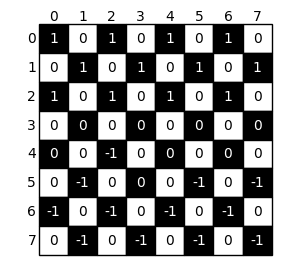

It's your turn, choose your move:


 11 15


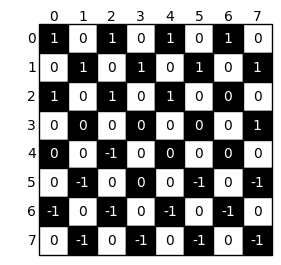

play vs W
its whites' turn


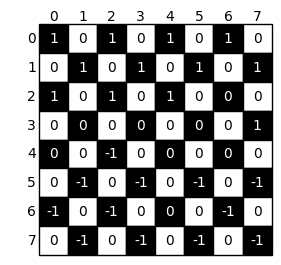

It's your turn, choose your move:


 9 12


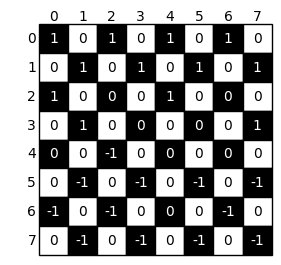

play vs W
its whites' turn


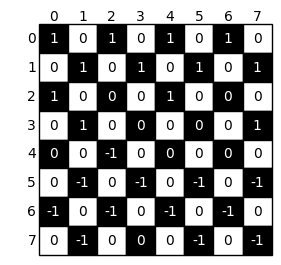

It's your turn, choose your move:


 10 13


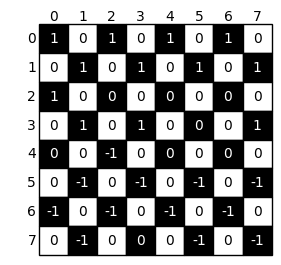

play vs W
its whites' turn


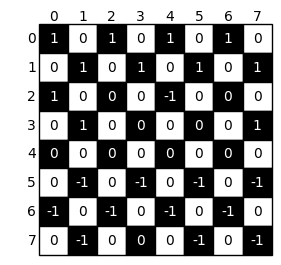

It's your turn, choose your move:


 6 10


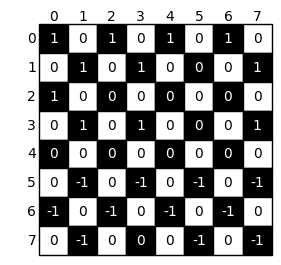

play vs W
its whites' turn


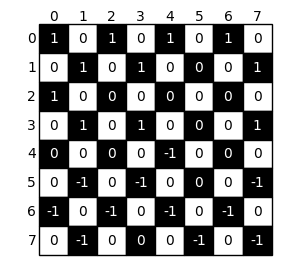

It's your turn, choose your move:


 13 18


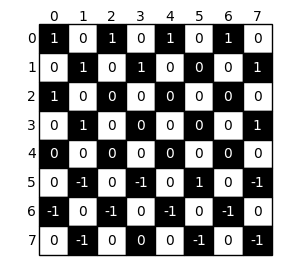

Force capture (22, 26)


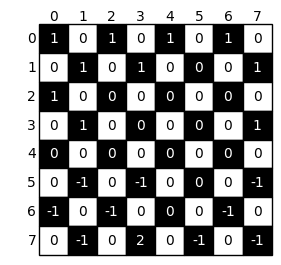

play vs W
its whites' turn


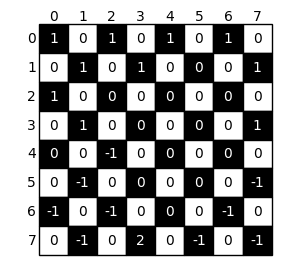

It's your turn, choose your move:


 12 17


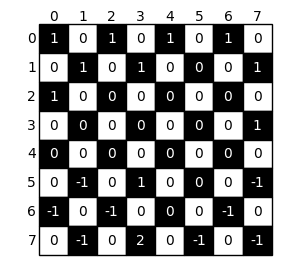

play vs W
its whites' turn


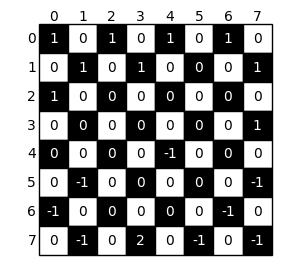

It's your turn, choose your move:


 29 26


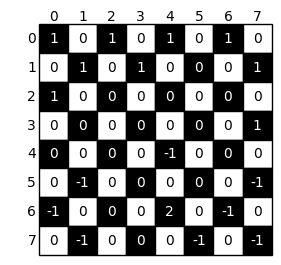

play vs W
its whites' turn


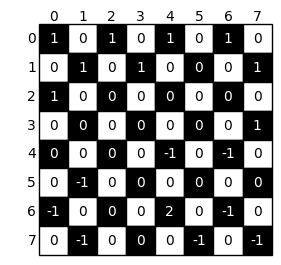

It's your turn, choose your move:


 15 19


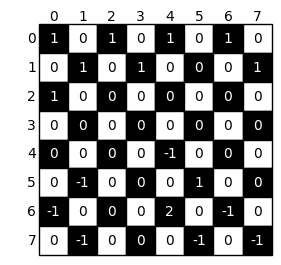

play vs W
its whites' turn


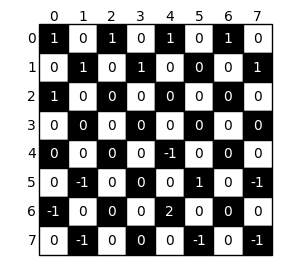

It's your turn, choose your move:


 26 21


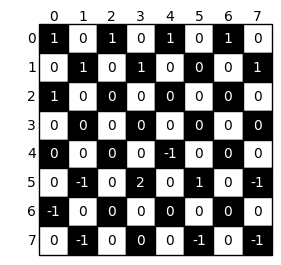

play vs W
its whites' turn


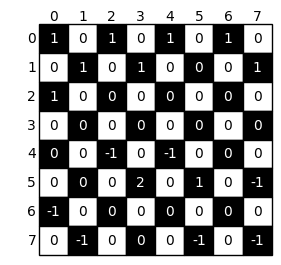

It's your turn, choose your move:


 21 18


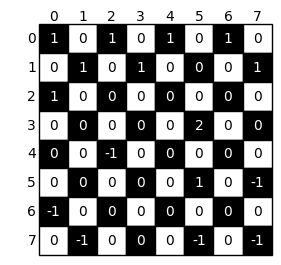

play vs W
its whites' turn


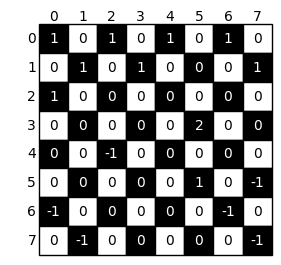

It's your turn, choose your move:


 22 26


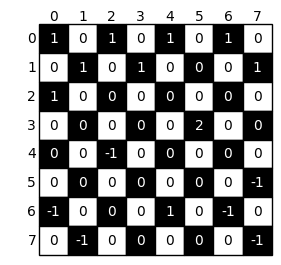

play vs W
its whites' turn


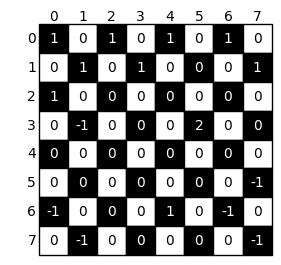

It's your turn, choose your move:


 8 12


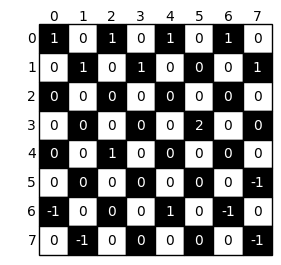

play vs W
its whites' turn


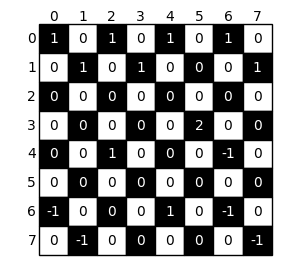

It's your turn, choose your move:


 14 19


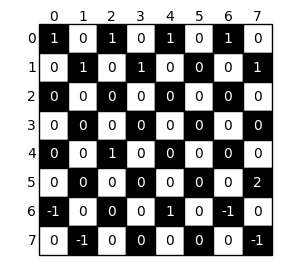

Force capture (23, 27)


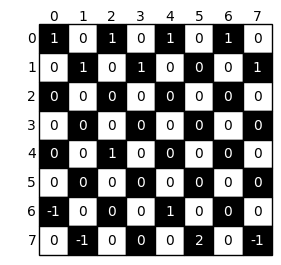

play vs W
its whites' turn


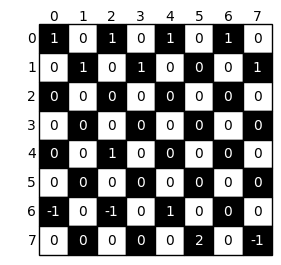

It's your turn, choose your move:


 30 27


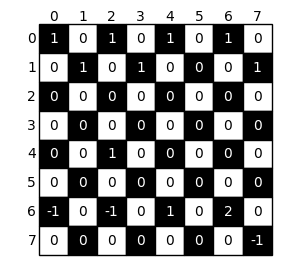

play vs W
its whites' turn


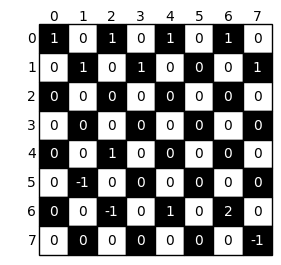

It's your turn, choose your move:


 17 20


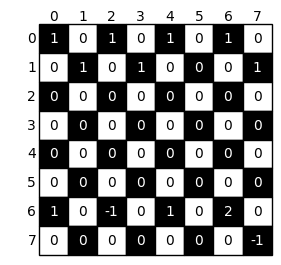

play vs W
its whites' turn


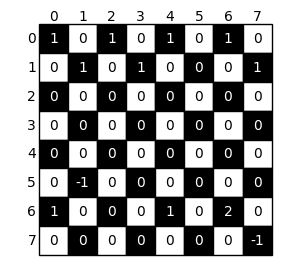

It's your turn, choose your move:


 4 8


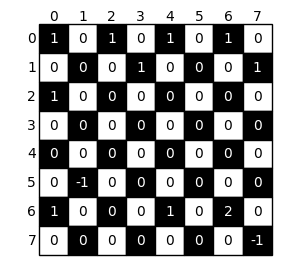

play vs W
its whites' turn


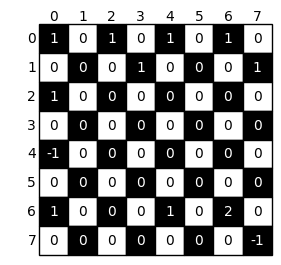

It's your turn, choose your move:


 5 9


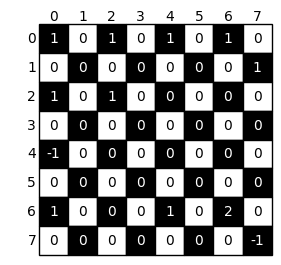

play vs W
its whites' turn


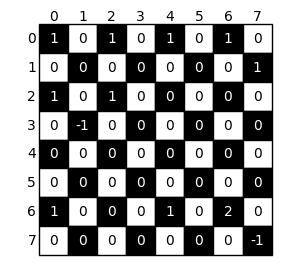

It's your turn, choose your move:


 9 12


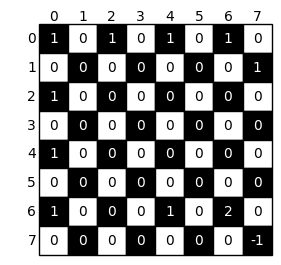

1

In [32]:
white_moves = {}
black_moves = {}
play_vs_white(board_1, -1, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, 1)

In [111]:
white_moves = {}

# OLD